In [1]:
import pandas as pd
import numpy as np
import tqdm
from pyspark.sql.window import Window
from sklearn.preprocessing import LabelEncoder
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark import SparkContext
from graphframes import GraphFrame
from pyspark.sql.types import *
import multiprocessing
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
import os
import shutil

In [2]:
spark_driver_memory = "10g"
spark_executor_memory = "6g"
spark_partial_results_folder = './partial_results'


spark = SparkSession.builder \
                    .config("spark.driver.memory", spark_driver_memory) \
                    .config("spark.executor.memory", spark_executor_memory) \
                    .master("local[*]") \
                    .config("spark.sql.autoBroadcastJoinThreshold", 100 * 1024 * 1024)\
                    .getOrCreate()
print("Spark session created")
sc = spark.sparkContext
print("Spark context created")


if not os.path.exists(spark_partial_results_folder):
    os.makedirs(spark_partial_results_folder)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/09 20:21:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark session created
Spark context created


In [3]:
schema = StructType([
    StructField('timestamp', StringType(), True),
    StructField('from_bank', IntegerType(), True),
    StructField('from_account', StringType(), True),
    StructField('to_bank', IntegerType(), True),
    StructField('to_account', StringType(), True),
    StructField('amount_received', FloatType(), True),
    StructField('receiving_currency', StringType(), True),
    StructField('amount_paid', FloatType(), True),
    StructField('payment_currency', StringType(), True),
    StructField('payment_format', StringType(), True),
    StructField('is_laundering', IntegerType(), True)])



spark_df = spark.read.csv("../dataset/HI-Small_Trans.csv", header = False, schema=schema)

In [4]:
spark_df = spark_df.withColumn("index", monotonically_increasing_id())
spark_df = spark_df.filter(col('index') > 0)
spark_df.show(5)

+----------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+-------------+-----+
|       timestamp|from_bank|from_account|to_bank|to_account|amount_received|receiving_currency|amount_paid|payment_currency|payment_format|is_laundering|index|
+----------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+-------------+-----+
|2022/09/01 00:20|       10|   8000EBD30|     10| 8000EBD30|        3697.34|         US Dollar|    3697.34|       US Dollar|  Reinvestment|            0|    1|
|2022/09/01 00:20|     3208|   8000F4580|      1| 8000F5340|           0.01|         US Dollar|       0.01|       US Dollar|        Cheque|            0|    2|
|2022/09/01 00:00|     3209|   8000F4670|   3209| 8000F4670|       14675.57|         US Dollar|   14675.57|       US Dollar|  Reinvestment|            0|    3|
|2022/09/01 00:02|       12|   8000F5030

# Proportion Laundering and not Laundering

In [5]:
total_count = spark_df.count()
spark_df.select('is_laundering').groupBy('is_laundering').agg(count('*').alias('count')).withColumn("proportion", col('count')/total_count).show(5, truncate=False)

+-------------+-------+---------------------+
|is_laundering|count  |proportion           |
+-------------+-------+---------------------+
|1            |5177   |0.0010194266045335635|
|0            |5073168|0.9989805733954664   |
+-------------+-------+---------------------+



# Display payment format in relation to laundering transaction

+--------------+----+-------+
|payment_format|1   |0      |
+--------------+----+-------+
|ACH           |4483|596314 |
|Cheque        |324 |1864007|
|Credit Card   |206 |1323118|
|Cash          |108 |490783 |
|Bitcoin       |56  |146035 |
|Reinvestment  |0   |481056 |
|Wire          |0   |171855 |
+--------------+----+-------+



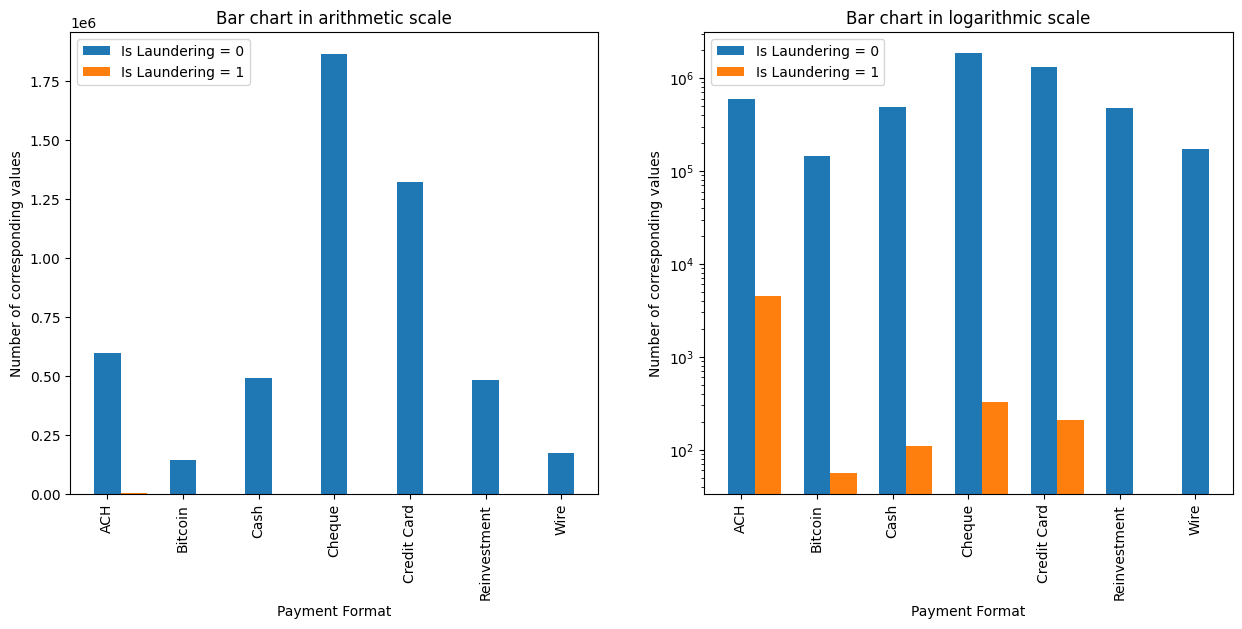

In [6]:
spark_df.select('payment_format', 'is_laundering') \
    .groupBy('payment_format') \
    .agg(
        sum(col('is_laundering').cast('int')).alias('1'),
        sum((1 - col('is_laundering')).cast('int')).alias('0')
    ).orderBy('1', ascending=False).show(truncate=False)

# Calculate the number of corresponding values for each value of the "Payment Format" and "Is Laundering" columns
grouped_df = spark_df.groupBy("payment_format", "is_laundering").count()

# Convert Spark DataFrame to Pandas DataFrame
count_values = grouped_df.toPandas()

# Use the unstack() method
count_values_payment = count_values.pivot(index='payment_format', columns='is_laundering', values='count')

# Create a bar chart with a logarithmic scale
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
bar_width = 0.35
bar_positions = range(len(count_values_payment.index))
axs[0].bar(bar_positions, count_values_payment[0], bar_width, label='Is Laundering = 0')
axs[0].bar([p + bar_width for p in bar_positions], count_values_payment[1], bar_width, label='Is Laundering = 1')
axs[0].set_xticks(bar_positions)
axs[0].set_xticklabels(count_values_payment.index, rotation='vertical') 
axs[0].set_xlabel('Payment Format')
axs[0].set_ylabel('Number of corresponding values')
axs[0].set_title('Bar chart in arithmetic scale')
axs[0].legend()

axs[1].bar(bar_positions, count_values_payment[0], bar_width, label='Is Laundering = 0')
axs[1].bar([p + bar_width for p in bar_positions], count_values_payment[1], bar_width, label='Is Laundering = 1')
axs[1].set_xticks(bar_positions)
axs[1].set_xticklabels(count_values_payment.index, rotation='vertical') 
axs[1].set_xlabel('Payment Format')
axs[1].set_ylabel('Number of corresponding values')
axs[1].set_title('Bar chart in logarithmic scale')
axs[1].legend()
axs[1].set_yscale('log')

# Show the chart
plt.show()


# Display payment currency in relation to laundering transaction

+-----------------+----+-------+
|payment_currency |1   |0      |
+-----------------+----+-------+
|US Dollar        |1912|1893260|
|Euro             |1372|1166925|
|Saudi Riyal      |374 |88640  |
|Swiss Franc      |193 |234667 |
|Yuan             |184 |213568 |
|Rupee            |167 |190035 |
|Yen              |155 |155054 |
|Ruble            |133 |155045 |
|UK Pound         |132 |180606 |
|Canadian Dollar  |128 |139914 |
|Australian Dollar|127 |136642 |
|Shekel           |95  |192089 |
|Mexican Peso     |92  |110067 |
|Brazil Real      |57  |70646  |
|Bitcoin          |56  |146010 |
+-----------------+----+-------+



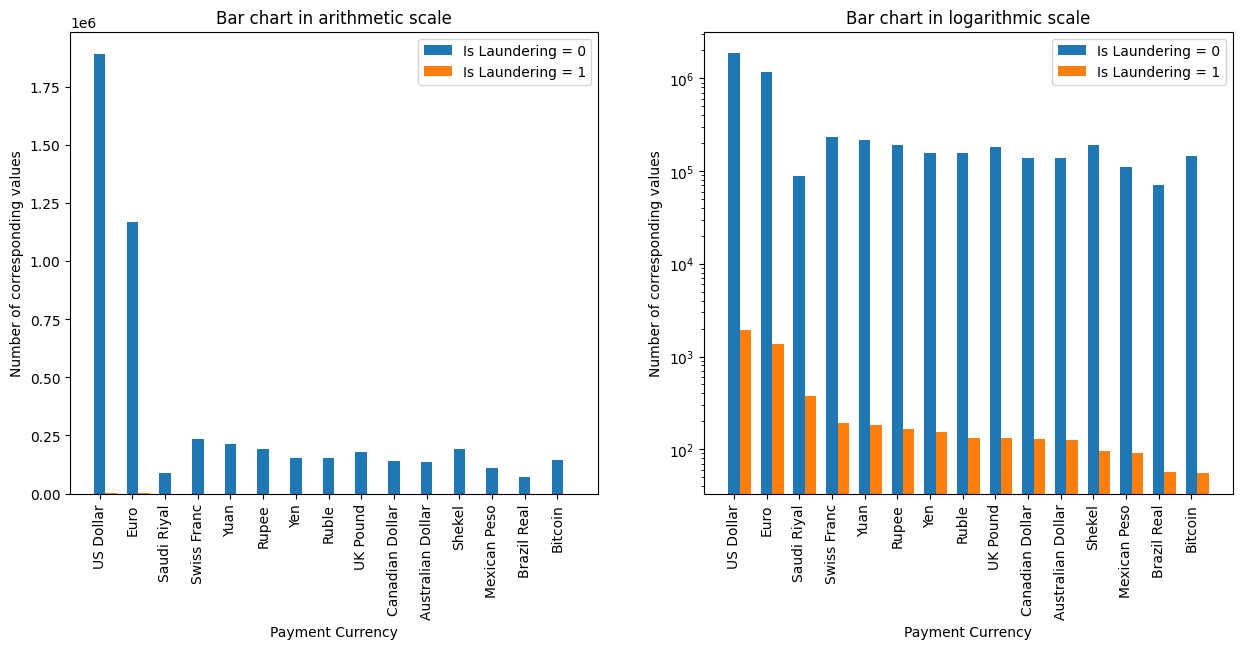

In [7]:
spark_df.select('payment_currency', 'is_laundering') \
    .groupBy('payment_currency') \
    .agg(
        sum(col('is_laundering').cast('int')).alias('1'),
        sum((1 - col('is_laundering')).cast('int')).alias('0')
    ).orderBy('1', ascending=False).show(truncate=False)

grouped_df = spark_df.groupBy("payment_currency", "is_laundering").count()

# Convert Spark DataFrame to Pandas DataFrame
count_values = grouped_df.toPandas()

# Use the unstack() method
count_values_currency = count_values.pivot(index='payment_currency', columns='is_laundering', values='count')

# Sort the values by Is Laundering = 1 in descending order
count_values_currency = count_values_currency.sort_values(1, ascending=False)

# Create a bar chart with a logarithmic scale
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
bar_width = 0.35
bar_positions = range(len(count_values_currency.index))
axs[0].bar(bar_positions, count_values_currency[0], bar_width, label='Is Laundering = 0')
axs[0].bar([p + bar_width for p in bar_positions], count_values_currency[1], bar_width, label='Is Laundering = 1')
axs[0].set_xticks(bar_positions)
axs[0].set_xticklabels(count_values_currency.index, rotation='vertical') 
axs[0].set_xticklabels(count_values_currency.index)
axs[0].set_xlabel('Payment Currency')
axs[0].set_ylabel('Number of corresponding values')
axs[0].set_title('Bar chart in arithmetic scale')
axs[0].legend()

axs[1].bar(bar_positions, count_values_currency[0], bar_width, label='Is Laundering = 0')
axs[1].bar([p + bar_width for p in bar_positions], count_values_currency[1], bar_width, label='Is Laundering = 1')
axs[1].set_xticks(bar_positions)
axs[1].set_xticklabels(count_values_currency.index, rotation='vertical') 
axs[1].set_xticklabels(count_values_currency.index)
axs[1].set_xlabel('Payment Currency')
axs[1].set_ylabel('Number of corresponding values')
axs[1].set_title('Bar chart in logarithmic scale')
axs[1].legend()
axs[1].set_yscale('log')

# Show the chart
plt.show()

# Display top 10 accounts for fraudolent transactions

In [8]:
spark_df.select(col('from_account').alias('account'), col('is_laundering'))\
.filter(col('is_laundering') == 1).groupBy('account')\
.agg(count('*').alias('count_laundering'))\
.orderBy('count_laundering', ascending=False)\
.show(10)

+---------+----------------+
|  account|count_laundering|
+---------+----------------+
|100428660|             243|
|1004286A8|             158|
|100428978|              29|
|80266F880|              29|
|100428810|              26|
|812D22980|              25|
|100428738|              23|
|811C599A0|              21|
|811C597B0|              21|
|8021353D0|              21|
+---------+----------------+
only showing top 10 rows



# Display top 20 accounts for transactions

In [9]:
spark_df.select(col('from_account').alias('account'))\
.groupBy('account')\
.agg(count('*').alias('count_transactions'))\
.orderBy('count_transactions', ascending=False)\
.show(20)

+---------+------------------+
|  account|count_transactions|
+---------+------------------+
|100428660|            168672|
|1004286A8|            103018|
|100428978|             20497|
|1004286F0|             18663|
|100428780|             17264|
|1004289C0|             16794|
|100428810|             16426|
|1004287C8|             14174|
|100428738|             13756|
|100428A51|             13073|
|1004288A0|             12330|
|100428858|             11000|
|1004288E8|              9471|
|100428A08|              8290|
|100428930|              6431|
|800058B80|               351|
|80006FCE0|               296|
|800058920|               279|
|80005ADE0|               276|
|800105F00|               274|
+---------+------------------+
only showing top 20 rows



# Display relationhip between amount paid and laundering transaction

In [10]:
grouped_stats = spark_df.groupBy('is_laundering').agg(
    min(col('amount_paid')).alias('min'),
    max(col('amount_paid')).alias('max'),
    mean(col('amount_paid')).alias('mean')
)

# Mostra le statistiche
grouped_stats.show()


"""# Estrai il DataFrame Spark come Pandas DataFrame
df_pd = spark_df.toPandas()

# Applica la scala logaritmica e la formattazione numerica
plt.yscale("log")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: format(x, ',.2f')))

# Crea il grafico scatter
plt.scatter(df_pd['is_laundering'], df_pd['amount_paid'], alpha=0.5)
plt.title("Relationship between Is Laundering and Amount Paid")
plt.xlabel("Is Laundering")
plt.ylabel("Amount Paid")
plt.xticks([0, 1])
plt.grid(True)
plt.show()"""

+-------------+--------+-------------+-------------------+
|is_laundering|     min|          max|               mean|
+-------------+--------+-------------+-------------------+
|            1|0.003227| 8.4853146E10|3.613531071586281E7|
|            0|  1.0E-6|1.04630236E12|  4477000.057857941|
+-------------+--------+-------------+-------------------+



'# Estrai il DataFrame Spark come Pandas DataFrame\ndf_pd = spark_df.toPandas()\n\n# Applica la scala logaritmica e la formattazione numerica\nplt.yscale("log")\nplt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: format(x, \',.2f\')))\n\n# Crea il grafico scatter\nplt.scatter(df_pd[\'is_laundering\'], df_pd[\'amount_paid\'], alpha=0.5)\nplt.title("Relationship between Is Laundering and Amount Paid")\nplt.xlabel("Is Laundering")\nplt.ylabel("Amount Paid")\nplt.xticks([0, 1])\nplt.grid(True)\nplt.show()'

# Analyze timestamp

In [5]:
spark_df = spark_df.withColumn("timestamp", to_timestamp("timestamp", "yyyy/MM/dd HH:mm"))

# Split the timestamp column into separate components
spark_df = spark_df.withColumn("year", year("timestamp"))\
                             .withColumn("month", month("timestamp"))\
                             .withColumn("day", dayofmonth("timestamp"))\
                             .withColumn("hour", hour("timestamp"))\
                             .withColumn("minute", minute("timestamp"))
spark_df.cache().count()
spark_df.show(5)

+-------------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+-------------+-----+----+-----+---+----+------+
|          timestamp|from_bank|from_account|to_bank|to_account|amount_received|receiving_currency|amount_paid|payment_currency|payment_format|is_laundering|index|year|month|day|hour|minute|
+-------------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+-------------+-----+----+-----+---+----+------+
|2022-09-01 00:20:00|       10|   8000EBD30|     10| 8000EBD30|        3697.34|         US Dollar|    3697.34|       US Dollar|  Reinvestment|            0|    1|2022|    9|  1|   0|    20|
|2022-09-01 00:20:00|     3208|   8000F4580|      1| 8000F5340|           0.01|         US Dollar|       0.01|       US Dollar|        Cheque|            0|    2|2022|    9|  1|   0|    20|
|2022-09-01 00:00:00|     3209|   8000F4670|   320

In [12]:
def laundering_for(col_name: str):
    print(f"Laundering for {col_name}")
    spark_df.select(col_name, 'is_laundering') \
    .groupBy(col_name) \
    .agg(
        sum(col('is_laundering').cast('int')).alias('count(1)'),
        sum((1 - col('is_laundering')).cast('int')).alias('count(0)'),
    ).withColumn("ratio", (col('count(1)')/col('count(0)')).cast('Decimal(20,6)')) \
  .orderBy(col('ratio').desc()) \
  .show(truncate=False)

In [13]:
laundering_for('year')
laundering_for('month')
laundering_for('day')
laundering_for('hour')
laundering_for('minute')

Laundering for year
+----+--------+--------+--------+
|year|count(1)|count(0)|ratio   |
+----+--------+--------+--------+
|2022|5177    |5073168 |0.001020|
+----+--------+--------+--------+

Laundering for month
+-----+--------+--------+--------+
|month|count(1)|count(0)|ratio   |
+-----+--------+--------+--------+
|9    |5177    |5073168 |0.001020|
+-----+--------+--------+--------+

Laundering for day
+---+--------+--------+--------+
|day|count(1)|count(0)|ratio   |
+---+--------+--------+--------+
|18 |8       |3       |2.666667|
|17 |15      |8       |1.875000|
|15 |28      |18      |1.555556|
|12 |170     |111     |1.531532|
|11 |232     |164     |1.414634|
|14 |70      |51      |1.372549|
|13 |106     |78      |1.358974|
|16 |26      |20      |1.300000|
|10 |442     |207883  |0.002126|
|4  |407     |207023  |0.001966|
|3  |391     |206991  |0.001889|
|8  |539     |482234  |0.001118|
|6  |531     |481558  |0.001103|
|7  |497     |482254  |0.001031|
|5  |471     |482179  |0.000977|

# Count the number of transaction an account receive in different period of time

In [6]:
def add_trans_received(df):
    window = Window.partitionBy('to_account', 'day')
    df = df.withColumn("transaction_received_per_day", count('*').over(window))

    window = Window.partitionBy('to_account', 'hour')
    df = df.withColumn("transaction_received_per_hour", count('*').over(window))

    window = Window.partitionBy('to_account', 'minute')
    df = df.withColumn("transaction_received_per_minute", count('*').over(window))

    return df.coalesce(48)


In [7]:
spark_df = add_trans_received(spark_df)

# Count the number of transaction an account send in different period of time

In [8]:
def add_trans_send(df):
    window = Window.partitionBy('from_account', 'day')
    df = df.withColumn("transaction_send_per_day", count('*').over(window))

    window = Window.partitionBy('from_account', 'hour')
    df = df.withColumn("transaction_send_per_hour", count('*').over(window))

    window = Window.partitionBy('from_account', 'minute')
    df = df.withColumn("transaction_send_per_minute", count('*').over(window))

    return df.coalesce(48)

In [9]:
spark_df = add_trans_send(spark_df)

In [18]:
spark_df.show()

+-------------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+-------------+-----------+----+-----+---+----+------+----------------------------+-----------------------------+-------------------------------+------------------------+-------------------------+---------------------------+
|          timestamp|from_bank|from_account|to_bank|to_account|amount_received|receiving_currency|amount_paid|payment_currency|payment_format|is_laundering|      index|year|month|day|hour|minute|transaction_received_per_day|transaction_received_per_hour|transaction_received_per_minute|transaction_send_per_day|transaction_send_per_hour|transaction_send_per_minute|
+-------------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+-------------+-----------+----+-----+---+----+------+----------------------------+-----------------------------+--------------

In [10]:
windowSpec = Window.partitionBy("from_account").orderBy("timestamp")

# Usa la funzione 'lag' per ottenere il timestamp della transazione precedente
spark_df = spark_df.withColumn("prev_timestamp", F.lag(spark_df.timestamp).over(windowSpec))

# Calcola la differenza in minuti
spark_df = spark_df.withColumn(
    "minutes_since_last_transaction", 
    F.when(
        F.isnull(spark_df.prev_timestamp), 
        -1
    ).otherwise(
        (F.unix_timestamp(spark_df.timestamp) - F.unix_timestamp(spark_df.prev_timestamp)) / 60
    )
)

# Seleziona le colonne desiderate
spark_df = spark_df.drop("prev_timestamp")

spark_df.show()

+-------------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+-------------+-----------+----+-----+---+----+------+----------------------------+-----------------------------+-------------------------------+------------------------+-------------------------+---------------------------+------------------------------+
|          timestamp|from_bank|from_account|to_bank|to_account|amount_received|receiving_currency|amount_paid|payment_currency|payment_format|is_laundering|      index|year|month|day|hour|minute|transaction_received_per_day|transaction_received_per_hour|transaction_received_per_minute|transaction_send_per_day|transaction_send_per_hour|transaction_send_per_minute|minutes_since_last_transaction|
+-------------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+-------------+-----------+----+-----+---+----+------+-----------

In [15]:
windowSpec = Window.partitionBy("from_account").orderBy("timestamp").rowsBetween(Window.unboundedPreceding, -1)

# Calcola l'importo medio delle transazioni precedenti
spark_df = spark_df.withColumn("avg_previous_amount", F.coalesce(F.avg("amount_received").over(windowSpec), F.lit(0)))

# Calcola la variazione dell'importo e utilizza 0 come valore di default se è nulla
spark_df = spark_df.withColumn("amount_variation", F.coalesce(F.col("amount_received") - F.col("avg_previous_amount"), F.lit(0)))

# Mostra il risultato
spark_df.show()


+-------------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+-------------+-----------+----+-----+---+----+------+----------------------------+-----------------------------+-------------------------------+------------------------+-------------------------+---------------------------+------------------------------+-------------------+-------------------+
|          timestamp|from_bank|from_account|to_bank|to_account|amount_received|receiving_currency|amount_paid|payment_currency|payment_format|is_laundering|      index|year|month|day|hour|minute|transaction_received_per_day|transaction_received_per_hour|transaction_received_per_minute|transaction_send_per_day|transaction_send_per_hour|transaction_send_per_minute|minutes_since_last_transaction|avg_previous_amount|   amount_variation|
+-------------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------

In [11]:
spark_df = spark_df.withColumn("timestamp_minutes", F.unix_timestamp("timestamp")/60)

# Crea una finestra partizionata per from_account e ordinata per timestamp_minutes
# e limita la finestra alle ultime 24 ore (1440 minuti)
windowSpec = Window.partitionBy("from_account").orderBy("timestamp_minutes")\
            .rangeBetween(-1440, Window.currentRow)

# Calcola i diversi to_bank e to_account univoci all'interno della finestra
spark_df = spark_df.withColumn("unique_to_banks_last_24h", F.collect_set("to_bank").over(windowSpec))
spark_df = spark_df.withColumn("unique_to_accounts_last_24h", F.collect_set("to_account").over(windowSpec))
spark_df = spark_df.drop('timestamp_minutes')

# Mostra il risultato
spark_df.show()

23/08/09 20:08:38 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+-------------+-----------+----+-----+---+----+------+----------------------------+-----------------------------+-------------------------------+------------------------+-------------------------+---------------------------+------------------------------+------------------------+---------------------------+
|          timestamp|from_bank|from_account|to_bank|to_account|amount_received|receiving_currency|amount_paid|payment_currency|payment_format|is_laundering|      index|year|month|day|hour|minute|transaction_received_per_day|transaction_received_per_hour|transaction_received_per_minute|transaction_send_per_day|transaction_send_per_hour|transaction_send_per_minute|minutes_since_last_transaction|unique_to_banks_last_24h|unique_to_accounts_last_24h|
+-------------------+---------+------------+-------+----------+---------------+------------------+--

In [12]:
spark_df = spark_df.drop('unique_to_accounts_last_24h').drop('unique_to_banks_last_24h').drop('timestamp_minutes')

In [13]:
spark_df.cache()

DataFrame[timestamp: timestamp, from_bank: int, from_account: string, to_bank: int, to_account: string, amount_received: float, receiving_currency: string, amount_paid: float, payment_currency: string, payment_format: string, is_laundering: int, index: bigint, year: int, month: int, day: int, hour: int, minute: int, transaction_received_per_day: bigint, transaction_received_per_hour: bigint, transaction_received_per_minute: bigint, transaction_send_per_day: bigint, transaction_send_per_hour: bigint, transaction_send_per_minute: bigint, minutes_since_last_transaction: double]

In [14]:
spark_df = spark_df.drop('timestamp_minutes')

# Label Encoding values

In [16]:
def label_columns(df, col1, col2 = None):
    unique_columns = set(df.select(col1).orderBy(col1).distinct().rdd.flatMap(lambda x: x).collect())
    if(col2 != None):
        unique_columns.update(df.select(col2).distinct().rdd.flatMap(lambda x: x).collect())

    # Create a dictionary to map accounts to indexes
    column_to_index = {column: index for index, column in enumerate(unique_columns)}

    # Create a UDF to map accounts to their indexes
    from pyspark.sql.functions import udf
    from pyspark.sql.types import IntegerType

    column_to_index_udf = udf(lambda column: column_to_index[column], IntegerType())

    # Add indexed columns to the DataFrame
    df_to_return = df.withColumn(f"{col1}_indexed", column_to_index_udf(col(col1))).drop(col1).withColumnRenamed(f'{col1}_indexed', col1) 
    if(col2!=None):
        df_to_return = df_to_return.withColumn(f"{col2}_indexed", column_to_index_udf(col(col2))).drop(col2).withColumnRenamed(f'{col2}_indexed', col2)
    return df_to_return


In [17]:
spark_df = label_columns(spark_df, 'from_account', 'to_account')
spark_df = label_columns(spark_df, 'receiving_currency', 'payment_currency')
spark_df = label_columns(spark_df, 'payment_format')

# More correlation among Accounts


Find how many times an Account send laund money and not laund money to the same Account.1

In [ ]:
df_temp = spark_df.select('from_account', 'to_account', 'is_laundering')

# Raggruppa e conta le occorrenze uniche
grouped_df = df_temp.groupBy('from_account', 'to_account').agg(collect_set('is_laundering').alias('unique_values'))

# Filtra i risultati con più di una occorrenza
filtered_df = grouped_df.filter(col('unique_values').getItem(0) != col('unique_values').getItem(1))

# Calcola il numero di occorrenze filtrate per ogni 'from_account'
result_df = filtered_df.groupBy('from_account').count().orderBy(col('count').desc())

# Mostra i primi 10 risultati
result_df.show(10)

In [18]:
spark_df = spark_df.withColumn("timestamp",
    concat_ws("",
        year("timestamp"),
        lpad(month("timestamp"), 2, "0"),
        lpad(dayofmonth("timestamp"), 2, "0"),
        lpad(hour("timestamp"), 2, "0"),
        lpad(minute("timestamp"), 2, "0")
    )
)
spark_df.withColumn("timestamp", date_format("timestamp", "yyyyMMddHHmm").cast(LongType()))

DataFrame[timestamp: bigint, from_bank: int, to_bank: int, amount_received: float, amount_paid: float, is_laundering: int, index: bigint, year: int, month: int, day: int, hour: int, minute: int, transaction_received_per_day: bigint, transaction_received_per_hour: bigint, transaction_received_per_minute: bigint, transaction_send_per_day: bigint, transaction_send_per_hour: bigint, transaction_send_per_minute: bigint, minutes_since_last_transaction: double, avg_previous_amount: double, amount_variation: double, from_account: int, to_account: int, receiving_currency: int, payment_currency: int, payment_format: int]

# Save first part of analysis

In [19]:
spark_df.coalesce(48).write.parquet('df.parquet', mode='overwrite')
spark_df.unpersist()

DataFrame[timestamp: string, from_bank: int, to_bank: int, amount_received: float, amount_paid: float, is_laundering: int, index: bigint, year: int, month: int, day: int, hour: int, minute: int, transaction_received_per_day: bigint, transaction_received_per_hour: bigint, transaction_received_per_minute: bigint, transaction_send_per_day: bigint, transaction_send_per_hour: bigint, transaction_send_per_minute: bigint, minutes_since_last_transaction: double, avg_previous_amount: double, amount_variation: double, from_account: int, to_account: int, receiving_currency: int, payment_currency: int, payment_format: int]

In [ ]:
df = spark.read.parquet('df.parquet2').drop("__index_level_0__")
df.persist().count()
df.orderBy('index').show(5)

# Using graph frame to work with graph

Find all transactions that are send from A to B with a certain value and from B to C with the same value. 

In [12]:
combinations = {}
values = list(df.select("payment_format").distinct().collect())
j = 0
for i in range(len(values)):
    for k in range(0, len(values)):
        combinations[(i,k)] = j
        j+=1

In [11]:
def add_money_send_to_send(df):

    # Create GraphFrame
    g = GraphFrame(
        df.select(F.col("from_account").alias("id")).union(df.select(F.col("to_account").alias("id"))).dropDuplicates(['id']),
        df.select(
            F.col("from_account").alias("src"),
            F.col("to_account").alias("dst"),
            F.col("index"),
            F.col("amount_paid").alias("amount"),
            F.col("timestamp"),
            F.col("payment_format"),
            F.col("is_laundering")
        )
    )
    
    # Define schema
    schema = StructType([
        StructField("index", LongType(), False),
        StructField("timestamp", DoubleType(), False),
        StructField("from", IntegerType(), False),
        StructField("to", IntegerType(), False),
        StructField("payment_format", IntegerType(), False),
        StructField("is_laundering", IntegerType(), False),
        StructField("payment_payment", IntegerType(), False)
    ])
    
    # Filter graph
    motif = "(a)-[c1]->(b); (b)-[c2]->(c)"
    graph = g.find(motif).filter("a != b and b != c and c1.amount == c2.amount and c1.timestamp < c2.timestamp").distinct()
    pattern = np.array(graph.select('c1', 'c2').collect()).squeeze()

    total_rows = []
    for row in pattern:
        rows = [[int(r[2]), float(r[4]), int(r[0]), int(r[1]), int(r[5]), int(r[6]), combinations[(int(row[0][5]), int(row[1][5]))]] for r in (row if isinstance(row[1], np.ndarray) else [row])]
        total_rows.extend(rows)
    
    # Create DataFrame
    temp_df = spark.createDataFrame(total_rows, schema).coalesce(48).dropDuplicates(['index'])

    # Join DataFrames
    df = df.join(
        broadcast(temp_df.select("index", "payment_payment").withColumnRenamed("payment_payment", "payment_payment_B")),
        on="index",
        how="left"
    ).withColumn(
        "payment_payment", 
        F.when(F.col("payment_payment_B").isNotNull(), F.col("payment_payment_B")).otherwise(-1)
    ).drop("payment_payment_B").coalesce(48).write.parquet(os.path.join(spark_partial_results_folder, 'partial_df'), mode='overwrite')
    
    return spark.read.parquet(os.path.join(spark_partial_results_folder, 'partial_df')).cache()

In [ ]:
df = add_money_send_to_send(df)

In [ ]:
df.write.parquet('df.parquet2', mode='overwrite')
df.unpersist()
df = spark.read.parquet('df.parquet2')
df.cache().count()

## Find circular patterns

In [ ]:
def find_cycles(df):

    schema = StructType([
        StructField("index", LongType(), False),
        StructField("timestamp", FloatType(), False),
        StructField("from", IntegerType(), False),
        StructField("to", IntegerType(), False),
        StructField("payment_format", IntegerType(), False),
        StructField("is_laundering", IntegerType(), False),
        StructField("hop_2", IntegerType(), False),
        StructField("hop_3", IntegerType(), False),
        StructField("hop_4", IntegerType(), False),
        StructField("hop_5", IntegerType(), False),
        StructField("hop_6", IntegerType(), False),
        StructField("hop_7", IntegerType(), False),
        StructField("hop_8", IntegerType(), False),
        StructField("hop_9", IntegerType(), False),
        StructField("hop_10", IntegerType(), False),
        StructField("hop_11", IntegerType(), False),
        StructField("hop_12", IntegerType(), False),
        StructField("hop_13", IntegerType(), False),
    ])


    all_df = []
    filtered_spark = df.filter(F.col("payment_currency") == F.col("receiving_currency"))
    filtered_spark.cache()
    #payment_formats = filtered_spark.select("payment_format").distinct().rdd.flatMap(lambda x: x).collect()

    for k in range(1):
        verteces = filtered_spark.filter(F.col("payment_format") == 2).select(F.col("from_account").alias("id")).union(filtered_spark.filter(F.col("payment_format") == 2).select(F.col("to_account").alias("id"))).distinct()
        edges = filtered_spark.filter(F.col("payment_format") == 2).select(F.col("from_account").alias("src"), F.col("to_account").alias("dst"), F.col("index"), F.col("amount_paid").alias("amount"), F.col("timestamp"), F.col("payment_format"), F.col("is_laundering"))
        g = GraphFrame(verteces, edges)
        g = g.dropIsolatedVertices()
        g.cache()
        for hop in tqdm.tqdm(range(2,14)):
            
            motif = ""

            for i in range(hop):
                motif += "(n" + str(i) + ")-[c" + str(i+1) + "]->(n" + str((i+1) % hop) + "); "
            motif = motif.strip("; ")

            filter_string = ""
            for i in range(hop):
                for j in range(i, hop-1):
                    filter_string += "n{} != n{}".format(i, j+1)
                    if i+1 < hop-1:
                        filter_string += " and "
            filter_string += " and "
            for j in range(1,hop):
                    filter_string += "c{}.timestamp < c{}.timestamp".format(j, j+1)
                    if(j+1 < hop):
                        filter_string += " and "    
            select_col = []
            for i in range(hop):
                select_col.append("c{}".format(i+1))
            pattern_g = g.find(motif).filter(filter_string)
            pattern = np.array(pattern_g.select(*select_col).collect()).squeeze()
            total_rows = []

            for row in pattern:
                if isinstance(row[1], np.ndarray):
                    for r in row:
                        #index | timestamp | from | to | payment_format | is_laundering | hop
                        total_rows.append([int(r[2]), float(r[4]), int(r[0]), int(r[1]), int(r[5]), int(r[6]), hop])
                else:
                    total_rows.append([int(row[2]), float(row[4]), int(row[0]), int(row[1]), int(row[5]), int(row[6]), hop])
            
            dataframe = pd.DataFrame(total_rows, columns=['index', 'timestamp', 'from', 'to', 'payment_format', 'is_laundering', 'hop'])

            all_df.append(dataframe.drop_duplicates())
        g.unpersist()
        filtered_spark.unpersist()
 
    merged_df = pd.concat(all_df, ignore_index=True)
    one_hot_encoded_df = pd.get_dummies(merged_df, columns=['hop'], prefix='hop')

    columns_to_add = [f"hop_{i}" for i in range(2, 14)]
    for col in columns_to_add:
        if col not in one_hot_encoded_df.columns:
            one_hot_encoded_df[col] = False

    grouped_df = one_hot_encoded_df.groupby('index').agg({
        'timestamp': 'first',
        'from': 'first',
        'to': 'first',
        'payment_format': 'first',
        'is_laundering': 'first',
        **{col: 'any' for col in columns_to_add}
    }).reset_index()
   
    columns_to_encode = ['hop_2', 'hop_3', 'hop_4', 'hop_5', 'hop_6', 'hop_7', 'hop_8', 'hop_9', 'hop_10', 'hop_11', 'hop_12', 'hop_13']
    grouped_df[columns_to_encode] = grouped_df[columns_to_encode].fillna(False, inplace=False).astype(int)
    
    temp_df = spark.createDataFrame(grouped_df, schema)

    temp_df = temp_df.dropDuplicates(['index'])

    # Step 1: Seleziona solo le colonne necessarie da temp_df e rinomina le colonne
    temp_df_selected = temp_df.select(
        "index",
        "hop_2", "hop_3", "hop_4", "hop_5", "hop_6",
        "hop_7", "hop_8", "hop_9", "hop_10", "hop_11",
        "hop_12", "hop_13"
    ).withColumnRenamed("hop_2", "hop_2_B").withColumnRenamed("hop_3", "hop_3_B").withColumnRenamed("hop_4", "hop_4_B").withColumnRenamed("hop_5", "hop_5_B").withColumnRenamed("hop_6", "hop_6_B").withColumnRenamed("hop_7", "hop_7_B").withColumnRenamed("hop_8", "hop_8_B").withColumnRenamed("hop_9", "hop_9_B").withColumnRenamed("hop_10", "hop_10_B").withColumnRenamed("hop_11", "hop_11_B").withColumnRenamed("hop_12", "hop_12_B").withColumnRenamed("hop_13", "hop_13_B")

    # Step 2: Esegui una left join tra df e temp_df_selected, usando l'indice come chiave di join
    joined_df = df.join(temp_df_selected, on="index", how="left")

    # Step 3: Usa la funzione when per assegnare il valore corrispondente da hop_i_B se presente, altrimenti imposta il valore a 0
    for i in range(2, 14):
        joined_df = joined_df.withColumn(
            f"hop_{i}", 
            F.when(F.col(f"hop_{i}_B").isNotNull(), F.col(f"hop_{i}_B")).otherwise(0)
        )

    # Step 4: Rimuovi le colonne aggiunte da temp_df_selected
    joined_df = joined_df.drop(*[f"hop_{i}_B" for i in range(2, 14)])
    
    joined_df.write.parquet(os.path.join(spark_partial_results_folder, 'partial_df'), mode='overwrite')
    # Il risultato finale è il dataframe df con le colonne hop_2 a hop_13 aggiunte e i valori 0 dove necessario
    df.unpersist()
    
    
    return spark.read.parquet(os.path.join(spark_partial_results_folder, 'partial_df')).repartition(48).cache()

In [ ]:
df = find_cycles(df)

In [ ]:
df.write.parquet('df.parquet2', mode='overwrite')
df.unpersist()
df = spark.read.parquet('df.parquet2')
df.cache().count()

# Find fan in

In [10]:
def find_fanin(g: GraphFrame):
    motif = "(a)-[c1]->(b); (c)-[c2]->(b)"
    filter_motif = "(abs(c1.timestamp - c2.timestamp)) <= 40000 and c1.index != c2.index and c1.payment_currency == c2.payment_currency"#and c1.payment_format == c2.payment_format"
    pattern = g.find(motif).filter(filter_motif).select("c1", "c2")
    pattern.coalesce(48)
    fan_in_trans = pattern.groupBy(col("c1")).agg(count("*").alias("fan_in_degree")).select(col("c1").alias("transaction"), col("fan_in_degree"))
    
    
    return fan_in_trans.distinct()

def add_fan_in(df):
    filtered_spark = df.filter(col("payment_currency") == col("receiving_currency"))
    filtered_spark.cache()
    payment_formats = filtered_spark.select("payment_format").distinct().rdd.flatMap(lambda x: x).collect()

    total_fan_in = None

    for payment_format in payment_formats:
        filtered_by_format = filtered_spark.filter(col("payment_format") == payment_format)
        verteces = (
            filtered_by_format.select(col("from_account").alias("id"))
            .union(filtered_by_format.select(col("to_account").alias("id")))
            .distinct()
        )
        edges = (
            filtered_by_format.select(
                col("from_account").alias("src"),
                col("to_account").alias("dst"),
                col("index"),
                col("timestamp"),
                col("payment_currency"),
                col("payment_format"),
                col("is_laundering")
                
            )
        )
        g = GraphFrame(verteces, edges)
        find_fanin(g).coalesce(48).write.parquet(os.path.join(spark_partial_results_folder, f'fanin_{payment_format}'), mode='overwrite')
        """all_fan_ins = []
        if total_fan_in is None:
            find_fanin(g).repartition(48).write.parquet(os.path.join(spark_partial_results_folder, f'_{payment_format}'))
            fan_in = find_fanin(g)
            total_fan_in = fan_in
            all_fan_ins.append(fan_in)
        else:
            fan_in = find_fanin(g)
            total_fan_in = total_fan_in.union(fan_in)  
            all_fan_ins.append(fan_in)
            total_fan_in = total_fan_in.coalesce(48)"""
        
    total_fan_in = None
    for payment_format in payment_formats:
        if total_fan_in is None: 
            total_fan_in = spark.read.parquet(os.path.join(spark_partial_results_folder, f'fanin_{payment_format}'))
        else:
            total_fan_in.union(spark.read.parquet(os.path.join(spark_partial_results_folder, f'fanin_{payment_format}')))

    temp_df = total_fan_in.select("transaction.*", "fan_in_degree")
   

    joined_df = df.join(broadcast(temp_df.select("index", col("fan_in_degree").alias("fan_in_degree_B"))), on="index", how="left")
    

    # Aggiungi la colonna "payment_payment" a dfA, usando il valore corrispondente da dfB se presente, altrimenti imposta -1
    df = joined_df.withColumn("fan_in_degree", F.when(F.col("fan_in_degree_B").isNotNull(), F.col("fan_in_degree_B")).otherwise(0)).drop("fan_in_degree_B")
    df.coalesce(48).write.parquet(os.path.join(spark_partial_results_folder, 'partial_df'), mode='overwrite')
    for payment_format in payment_formats:
        shutil.rmtree(os.path.join(spark_partial_results_folder, f'fanin_{payment_format}'))

        
    filtered_spark.unpersist()
    df.unpersist()    
    return spark.read.parquet(os.path.join(spark_partial_results_folder, 'partial_df')).repartition(48).cache()

In [ ]:
df = add_fan_in(df)

In [ ]:
df.write.parquet('df.parquet2', mode='overwrite')
df.unpersist()
df = spark.read.parquet('df.parquet2')
df.cache().count()

# Find fan out

In [8]:
def find_fanout(g: GraphFrame):
    motif = "(a)-[c1]->(b); (a)-[c2]->(c)"
    filter_motif = "(abs(c1.timestamp - c2.timestamp)) <= 40000 and c1.index != c2.index"
    pattern = g.find(motif).filter(filter_motif).select("c1", "c2")
    pattern.coalesce(48)
    return pattern.groupBy(F.col("c1")).agg(F.count("*").alias("fan_out_degree")).select(F.col("c1").alias("transaction"), F.col("fan_out_degree")).distinct()

def add_fatn_out(df):
    filtered_spark = df.filter(F.col("payment_currency") == F.col("receiving_currency")).cache()
    
    payment_format = 2  # Assuming you wanted to only process for payment_format = 2
    print(f"Find fan out payment_format: {payment_format}")
    
    filtered_by_format = filtered_spark.filter(F.col("payment_format") == payment_format).cache()
    
    verteces = (
        filtered_by_format.select(F.col("from_account").alias("id"))
        .union(filtered_by_format.select(F.col("to_account").alias("id")))
        .distinct()
    )
    edges = filtered_by_format.select(
        F.col("from_account").alias("src"),
        F.col("to_account").alias("dst"),
        F.col("index"),
        F.col("timestamp"),
        F.col("payment_format"),
        F.col("is_laundering")
    ).coalesce(48)
    
    g = GraphFrame(verteces, edges)
    find_fanout(g).coalesce(48).write.parquet(os.path.join(spark_partial_results_folder, f'fanout_{payment_format}'), mode='overwrite')
    
    g.unpersist()
    filtered_by_format.unpersist() 

    total_fan_out = spark.read.parquet(os.path.join(spark_partial_results_folder, f'fanout_{payment_format}'))
    temp_df = total_fan_out.select("transaction.*", "fan_out_degree")
    joined_df = df.join(broadcast(temp_df.select("index", col("fan_out_degree").alias("fan_out_degree_B"))), on="index", how="left")
    df = joined_df.withColumn("fan_out_degree", F.when(F.col("fan_out_degree_B").isNotNull(), F.col("fan_out_degree_B")).otherwise(0)).drop("fan_out_degree_B")
    
    df.coalesce(48).write.parquet(os.path.join(spark_partial_results_folder, 'partial_df'), mode='overwrite')
    shutil.rmtree(os.path.join(spark_partial_results_folder, f'fanout_{payment_format}'))
    df.unpersist()
    return spark.read.parquet(os.path.join(spark_partial_results_folder, 'partial_df')).persist()

In [9]:
def find_fanout(g: GraphFrame):
    motif = "(a)-[c1]->(b); (a)-[c2]->(c)"
    filter_motif = "(abs(c1.timestamp - c2.timestamp)) <= 40000 and c1.index != c2.index"
    pattern = g.find(motif).filter(filter_motif).select("c1", "c2")
    pattern.coalesce(48)
    return pattern.groupBy(F.col("c1")).agg(F.count("*").alias("fan_out_degree")).select(F.col("c1").alias("transaction"), F.col("fan_out_degree")).dropDuplicates(['transaction'])


def add_fan_out(df):
    filtered_spark = df.filter(col("payment_currency") == col("receiving_currency"))
    filtered_spark.cache()
    payment_formats = filtered_spark.select("payment_format").distinct().rdd.flatMap(lambda x: x).collect()

    for payment_format in payment_formats:
        filtered_by_format = filtered_spark.filter(col("payment_format") == payment_format)
        verteces = (
            filtered_by_format.select(col("from_account").alias("id"))
            .union(filtered_by_format.select(col("to_account").alias("id")))
            .distinct()
        )
        edges = filtered_by_format.select(
            F.col("from_account").alias("src"),
            F.col("to_account").alias("dst"),
            F.col("index"),
            F.col("timestamp"),
            F.col("payment_format"),
            F.col("is_laundering")
        ).coalesce(48)
        g = GraphFrame(verteces, edges)
        find_fanout(g).coalesce(48).write.parquet(os.path.join(spark_partial_results_folder, f'fanout_{payment_format}'), mode='overwrite')
        
        
    total_fan_out = None
    for payment_format in payment_formats:
        if total_fan_out is None: 
            total_fan_out = spark.read.parquet(os.path.join(spark_partial_results_folder, f'fanout_{payment_format}'))
        else:
            total_fan_out.union(spark.read.parquet(os.path.join(spark_partial_results_folder, f'fanout_{payment_format}')))

    temp_df = total_fan_out.select("transaction.*", "fan_out_degree")
   

    joined_df = df.join(broadcast(temp_df.select("index", col("fan_out_degree").alias("fan_out_degree_B"))), on="index", how="left")
    

    # Aggiungi la colonna "payment_payment" a dfA, usando il valore corrispondente da dfB se presente, altrimenti imposta -1
    joined_df = joined_df.withColumn("fan_out_degree", F.when(F.col("fan_out_degree_B").isNotNull(), F.col("fan_out_degree_B")).otherwise(0)).drop("fan_out_degree_B")
    joined_df.coalesce(48).write.parquet(os.path.join(spark_partial_results_folder, 'partial_df'), mode='overwrite')
    for payment_format in payment_formats:
        shutil.rmtree(os.path.join(spark_partial_results_folder, f'fanout_{payment_format}'))

        
    filtered_spark.unpersist()
    df.unpersist()    
    return spark.read.parquet(os.path.join(spark_partial_results_folder, 'partial_df')).repartition(48).cache()

In [ ]:
df = add_fan_out(df)

In [ ]:
df.write.parquet('df.parquet2', mode='overwrite')
df.unpersist()
df = spark.read.parquet('df.parquet2')
df.cache().count()

# Display correlation matrix for fraudolent transactions

In [36]:
df = spark.read.parquet('df.parquet').drop('year').drop('month').drop('from_bank').drop('to_bank').drop('index').drop('amount_received').drop('amount_paid')

23/08/10 14:41:40 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 56425873 ms exceeds timeout 120000 ms
23/08/10 14:41:40 WARN SparkContext: Killing executors is not supported by current scheduler.
23/08/10 14:41:41 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:113)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:112)
	at org.apache.spark.storage

In [28]:
windowSpec = Window.partitionBy("from_account", "to_account").orderBy("timestamp").rowsBetween(Window.unboundedPreceding, Window.currentRow)

# Calcola la ricorrenza delle transazioni
df = df.withColumn("transaction_recurrence", F.count("timestamp").over(windowSpec))

In [30]:
df = df.withColumn("timestamp_minutes", F.unix_timestamp("timestamp")/60)

# Crea una finestra partizionata per from_account e ordinata per timestamp_minutes
# e limita la finestra alle ultime 24 ore (1440 minuti)
windowSpec = Window.partitionBy("from_account").orderBy("timestamp_minutes")\
            .rangeBetween(-1440, Window.currentRow)

# Calcola i diversi payment_format utilizzati all'interno della finestra temporale
df = df.withColumn("unique_payment_formats_last_day", F.collect_set("payment_format").over(windowSpec))

# Calcola il numero di metodi di pagamento unici utilizzati
df = df.withColumn("num_unique_payment_formats_last_day", F.size("unique_payment_formats_last_day"))


In [31]:
# Crea una finestra partizionata per from_account e ordinata per timestamp_minutes
# e limita la finestra alle ultime 24 ore (1440 minuti)
windowSpec = Window.partitionBy("from_account").orderBy("timestamp_minutes")\
            .rangeBetween(-1440, Window.currentRow)

# Calcola i diversi payment_format utilizzati all'interno della finestra temporale
df = df.withColumn("unique_payment_currency_last_day", F.collect_set("payment_currency").over(windowSpec))

# Calcola il numero di metodi di pagamento unici utilizzati
df = df.withColumn("num_unique_payment_currency_last_day", F.size("unique_payment_currency_last_day"))

In [34]:
df = df.drop('timestamp_minutes').drop('unique_payment_formats_last_day').drop('unique_payment_currency_last_day')

In [20]:
df.show()

+-------------+---+----+------+----------------------------+-----------------------------+-------------------------------+------------------------+-------------------------+---------------------------+------------------------------+-------------------+-------------------+------------------+----------------+--------------+----------------------+-------------------------------+-----------------------------------+
|is_laundering|day|hour|minute|transaction_received_per_day|transaction_received_per_hour|transaction_received_per_minute|transaction_send_per_day|transaction_send_per_hour|transaction_send_per_minute|minutes_since_last_transaction|avg_previous_amount|   amount_variation|receiving_currency|payment_currency|payment_format|transaction_recurrence|unique_payment_formats_last_24h|num_unique_payment_formats_last_24h|
+-------------+---+----+------+----------------------------+-----------------------------+-------------------------------+------------------------+-----------------------

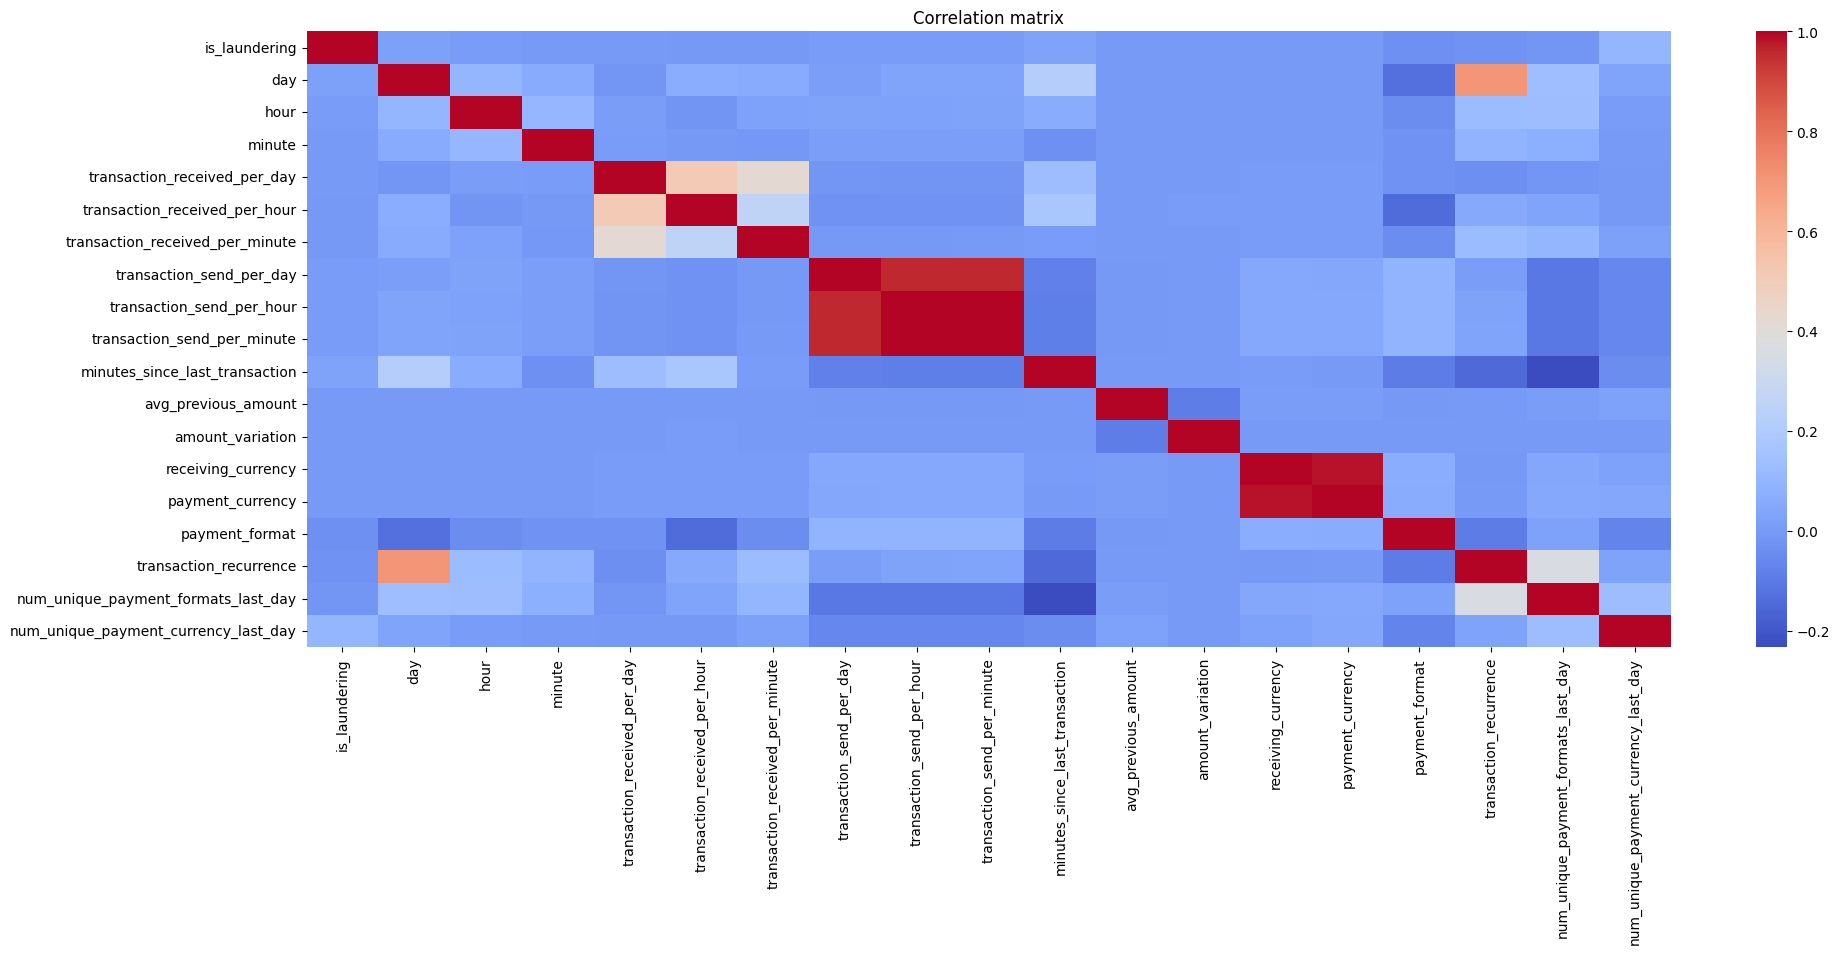

In [35]:
# Seleziona le colonne numeriche su cui calcolare la correlazione
numeric_columns = ['from_bank', 'to_bank', 'from_account', 'to_account','receiving_currency','payment_currency','payment_format', 'amount_received', 'amount_paid',  'day', 'hour', 'minute', 'transaction_received_per_day',  'transaction_received_per_hour',  'transaction_received_per_minute', 'transaction_send_per_day',  'transaction_send_per_hour',  'transaction_send_per_minute','payment_payment','hop_2', 'hop_3', 'hop_4', 'hop_5', 'hop_6', 'hop_7', 'hop_8', 'hop_9', 'hop_10', 'hop_11', 'hop_12', 'fan_in_degree', 'fan_out_degree', 'is_laundering']

# Crea un VectorAssembler per creare una singola colonna "features"
assembler = VectorAssembler(inputCols=df.columns, outputCol="features")
assembled_df = assembler.transform(df).select("features")


# Calcola la matrice di correlazione per entrambi i casi
laundering_corr_matrix = df.select(df.columns).toPandas().corr()

# create subplots

fig, ax = plt.subplots(figsize=(22, 8))

# plot the first correlation matrix heatmap
sns.heatmap(laundering_corr_matrix, cmap='coolwarm', annot=False, ax=ax)
ax.set_title('Correlation matrix')

# display the plot
plt.show()


# Create train validation and test

In [5]:
# Load and order the DataFrame
df = spark.read.parquet('df.parquet')
ordered_df = df.orderBy("timestamp")

# Calculate row counts for splits
total_rows = ordered_df.count()
train_rows, validation_rows = int(total_rows * 0.6), int(total_rows * 0.2)
test_rows = total_rows - train_rows - validation_rows

# Add a dummy partition and assign row numbers based on ordered timestamps
w = Window.partitionBy(lit(1)).orderBy("timestamp")
ordered_df = ordered_df.withColumn("row_number", F.row_number().over(w))

# Split and repartition the DataFrame into train, validation, and test sets based on row numbers
train_df = ordered_df.filter(col("row_number") <= train_rows).drop("row_number", "dummy_partition").repartition(48)
validation_df = ordered_df.filter(col("row_number").between(train_rows + 1, train_rows + validation_rows)).drop("row_number", "dummy_partition").repartition(48)
test_df = ordered_df.filter(col("row_number") > train_rows + validation_rows).drop("row_number", "dummy_partition").repartition(48)

In [6]:
def save_and_reload(df, name):
    df.repartition(48).write.parquet(f'./preprocessed_data/df.{name}', mode='overwrite')
    df.unpersist()
    df = spark.read.parquet(f'./preprocessed_data/df.{name}')
    df.cache()
    return df

In [7]:
def save_df(df, name):
    print("Adding transaction received...")
    df = add_trans_received(df)
    print("Adding transaction send...")
    df = add_trans_send(df)
    print("Adding money send to send...")
    df = add_money_send_to_send(df)
    #print("Adding cycles...")
    #df = find_cycles(df)
    print("Adding fan-in...")
    df = add_fan_in(df)
    print("Adding fan-out...")
    df = add_fan_out(df)
    shutil.move(os.path.join(spark_partial_results_folder, 'partial_df'), os.path.join('./to_preprocess', f'df.{name}'))
    


In [ ]:
spark.stop()

In [14]:
save_df(train_df, 'train')
save_df(validation_df, 'validation')
save_df(test_df, 'test')

Adding transaction received...
Adding transaction send...
Adding money send to send...


23/08/09 18:53:38 WARN CacheManager: Asked to cache already cached data.        


Adding fan-in...


Adding fan-out...


23/08/09 18:57:32 WARN CacheManager: Asked to cache already cached data.        


Adding transaction received...
Adding transaction send...
Adding money send to send...


23/08/09 18:57:51 WARN CacheManager: Asked to cache already cached data.        


Adding fan-in...


Adding fan-out...


23/08/09 18:58:57 WARN CacheManager: Asked to cache already cached data.        


Adding transaction received...
Adding transaction send...
Adding money send to send...


23/08/09 18:59:16 WARN CacheManager: Asked to cache already cached data.        


Adding fan-in...


Adding fan-out...


23/08/09 19:00:18 WARN CacheManager: Asked to cache already cached data.        


In [ ]:
df = spark.read.parquet('./preprocessed_data/df.train')